In [1]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

# Necessary

- Create VE
- Create dataset

In [2]:
import sys
import os
sys.path.append(os.path.abspath("/home/gdallagl/myworkdir/ESMSec/utils"))  # Adds current folder to Python path

import utils.my_functions as mf
import utils.models as my_models

import torch
import random
import time
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print(torch.__version__)

/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.5.0+cu121


In [3]:
# Configuration / hyperparameters
config = {
    "FLUID": "CSF",         # Dataset name
    "NUM_EPOCHS": 10,       # Total Epochs in training
    "EVAL_EPOCH_FREQ": 2,   # Evaluation frequency
    "BATCH_SIZE": 32,       # Batch size
    "LR": 5e-5,             # Learning rate
    "LR_DECAY_GAMMA": 1,    # Learning rate decay
    "LR_DECAY_STEPS_EPOCHS": 1000, # Learning rate decay steps
    "SEED": 43215,           # Random seed
    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CHECKPOINT_NAME": "facebook/esm2_t6_8M_UR50D", # ESM2 model name
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DATASET_PATH": "/home/gdallagl/myworkdir/ESMSec/data/protein/cyto_sec_dataset_claude.csv", # Path to dataset
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)
    "PATH_TO_SAVE_MODEL": "/home/gdallagl/myworkdir/models/ESMSec/CSF_trained_model.pth" # Path to save the model
}

# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

### Instantiate the model

In [4]:
# Load pre-trained ESM model
esm_model = AutoModel.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"],  cache_dir=config["PRETRAIN_ESM_CACHE_DIR"])
# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



In [5]:
# initialise model (ESM+ HEad)
net = my_models.EsmDeepSec(esm_model).to(config["DEVICE"])
# hidden dim of final embeggin of each aa after trnafoerm 
print("\nESM hidden dim", net.ESM_hidden_dim, "\n")


ESM hidden dim 320 



In [6]:
# Block ESM paramters to be trained
for param in net.esm_model.parameters():
    param.requires_grad = False

### Load dataset

In [7]:
# Load dataset
data = pd.read_csv(config["DATASET_PATH"])

# Truncate sequences and add as a new column
data['trunc_sequence'] = data['sequence'].apply(
    lambda seq: mf.truncate_sequence(seq, max_length=config["PROTEIN_MAX_LENGTH"])
)

# Tokenize all sequences at once (vectorized)
tokenized = tokenizer(
    data['trunc_sequence'].tolist(),
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)

# Add tokenized input_ids and attention_mask to DataFrame
data['input_ids'] = list(tokenized['input_ids'])
data['attention_mask'] = list(tokenized['attention_mask'])

# Convert labels to tensor
labels_tensor = torch.tensor(data['label'].values)

# Split indices
train_idx = data['set'] == 'train'
valid_idx = data['set'] == 'validation'
test_idx  = data['set'] == 'test'

# Train dataset (already using custom Dataset)
train_dataset = my_models.ProteinDataset(
    input_ids=tokenized['input_ids'][train_idx],
    attention_mask=tokenized['attention_mask'][train_idx],
    labels=labels_tensor[train_idx],
    names=data.loc[train_idx, "protein"].tolist()
)

# Validation dataset
valid_dataset = my_models.ProteinDataset(
    input_ids=tokenized['input_ids'][valid_idx],
    attention_mask=tokenized['attention_mask'][valid_idx],
    labels=labels_tensor[valid_idx],
    names=data.loc[valid_idx, "protein"].tolist()
)

# Test dataset
test_dataset = my_models.ProteinDataset(
    input_ids=tokenized['input_ids'][test_idx],
    attention_mask=tokenized['attention_mask'][test_idx],
    labels=labels_tensor[test_idx],
    names=data.loc[test_idx, "protein"].tolist()
)

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size=config["BATCH_SIZE"], shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size=config["BATCH_SIZE"], shuffle=False, pin_memory=True)
test_dl  = DataLoader(test_dataset, batch_size=config["BATCH_SIZE"], shuffle=False, pin_memory=True)

# Optional: inspect the DataFrame
display(data.head(5))
print(data.loc[0, "input_ids"])

,protein,sequence,label,set,trunc_sequence,input_ids,attention_mask
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,1,train,MRWQEMGYIFYPRKLR,"[tensor(0), tensor(20), tensor(10), tensor(22)...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,B2RUY7,MALHIHEACILLLVIPGLVTSAAISHEDYPADEGDQISSNDNLIFD...,1,train,MALHIHEACILLLVIPGLVTSAAISHEDYPADEGDQISSNDNLIFD...,"[tensor(0), tensor(20), tensor(5), tensor(4), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2,O00300,MNNLLCCALVFLDISIKWTTQETFPPKYLHYDEETSHQLLCDKCPP...,1,train,MNNLLCCALVFLDISIKWTTQETFPPKYLHYDEETSHQLLCDKCPP...,"[tensor(0), tensor(20), tensor(17), tensor(17)...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
3,O00560,MSLYPSLEDLKVDKVIQAQTAFSANPANPAILSEASAPIPHDGNLY...,1,train,MSLYPSLEDLKVDKVIQAQTAFSANPANPAILSEASAPIPHDGNLY...,"[tensor(0), tensor(20), tensor(8), tensor(4), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4,O00622,MSSRIARALALVVTLLHLTRLALSTCPAACHCPLEAPKCAPGVGLV...,1,validation,MSSRIARALALVVTLLHLTRLALSTCPAACHCPLEAPKCAPGVGLV...,"[tensor(0), tensor(20), tensor(8), tensor(8), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


tensor([ 0, 20, 10, 22, 16,  9, 20,  6, 19, 12, 18, 19, 14, 10, 15,  4, 10,  2,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1, 

<Axes: ylabel='Frequency'>

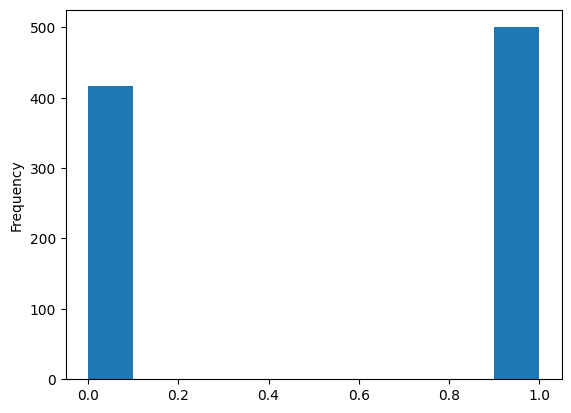

In [8]:
data["label"].plot(kind='hist')

### Train

In [9]:
results = mf.train(net, train_dl, valid_dl, test_dl, config)

Training:   0%|          | 0/10 [00:00<?, ?iter/s]

Training:  10%|█         | 1/10 [00:13<01:57, 13.03s/iter]

--- Evaluation at iteration 2 ---
	Train set: Loss: 0.5444, Acc: 80.66%, Balanced Acc: 79.80%, F1: 0.8342, MCC: 0.6123
	Validation set: Loss: 0.6079, Acc: 76.92%, Balanced Acc: 76.52%, F1: 0.7945, MCC: 0.5407


Training:  20%|██        | 2/10 [00:40<02:52, 21.57s/iter]

	Test set: Loss: 0.5554, Acc: 81.38%, Balanced Acc: 80.47%, F1: 0.8421, MCC: 0.6173
Allocated memory: 0.13 GB
Cached memory:    5.82 GB


Training:  30%|███       | 3/10 [00:53<02:03, 17.64s/iter]

--- Evaluation at iteration 4 ---
	Train set: Loss: 0.3933, Acc: 82.22%, Balanced Acc: 80.65%, F1: 0.8575, MCC: 0.6684
	Validation set: Loss: 0.5069, Acc: 79.23%, Balanced Acc: 78.37%, F1: 0.8302, MCC: 0.6184


Training:  40%|████      | 4/10 [01:21<02:10, 21.81s/iter]

	Test set: Loss: 0.4621, Acc: 82.76%, Balanced Acc: 80.65%, F1: 0.8634, MCC: 0.6556
Allocated memory: 0.13 GB
Cached memory:    5.82 GB


Training:  50%|█████     | 5/10 [01:34<01:32, 18.48s/iter]

--- Evaluation at iteration 6 ---
	Train set: Loss: 0.3127, Acc: 87.99%, Balanced Acc: 87.12%, F1: 0.8977, MCC: 0.7660
	Validation set: Loss: 0.4068, Acc: 83.85%, Balanced Acc: 83.28%, F1: 0.8609, MCC: 0.6919


Training:  60%|██████    | 6/10 [02:02<01:26, 21.62s/iter]

	Test set: Loss: 0.4146, Acc: 83.45%, Balanced Acc: 82.07%, F1: 0.8636, MCC: 0.6617
Allocated memory: 0.13 GB
Cached memory:    5.82 GB


Training:  70%|███████   | 7/10 [02:14<00:56, 18.74s/iter]

--- Evaluation at iteration 8 ---
	Train set: Loss: 0.2351, Acc: 90.17%, Balanced Acc: 90.05%, F1: 0.9101, MCC: 0.8017
	Validation set: Loss: 0.2674, Acc: 90.77%, Balanced Acc: 90.61%, F1: 0.9143, MCC: 0.8160


Training:  80%|████████  | 8/10 [02:42<00:43, 21.68s/iter]

	Test set: Loss: 0.3577, Acc: 86.21%, Balanced Acc: 86.12%, F1: 0.8780, MCC: 0.7197
Allocated memory: 0.13 GB
Cached memory:    5.82 GB


Training:  90%|█████████ | 9/10 [02:55<00:18, 18.87s/iter]

--- Evaluation at iteration 10 ---
	Train set: Loss: 0.2253, Acc: 91.58%, Balanced Acc: 91.40%, F1: 0.9235, MCC: 0.8301
	Validation set: Loss: 0.2889, Acc: 92.31%, Balanced Acc: 92.15%, F1: 0.9286, MCC: 0.8470


Training: 100%|██████████| 10/10 [03:23<00:00, 20.33s/iter]

	Test set: Loss: 0.3682, Acc: 86.21%, Balanced Acc: 86.12%, F1: 0.8780, MCC: 0.7197
Allocated memory: 0.13 GB
Cached memory:    5.82 GB


### Plot


=== Final Evaluation Metrics ===
Train   -> Loss: 0.2253, Accuracy: 91.58%
Valid   -> Loss: 0.2889, Accuracy: 92.31%
Test    -> Loss: 0.3682, Accuracy: 86.21%


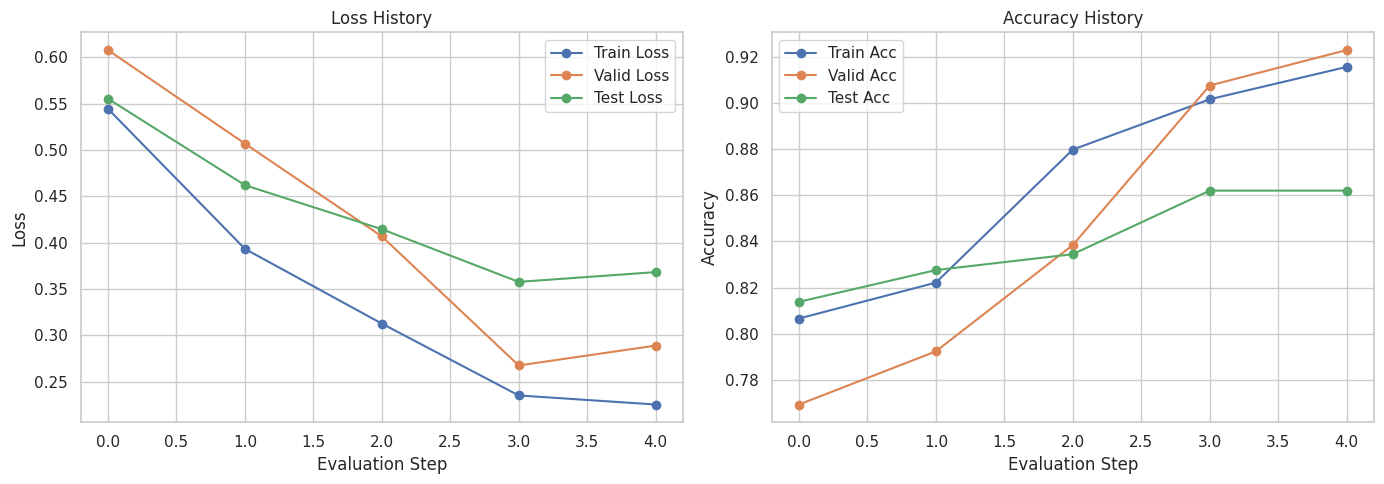

In [10]:
mf.summarize_training(*results)

### Save Model

In [11]:
torch.save(net, config["PATH_TO_SAVE_MODEL"])

RuntimeError: Parent directory /home/gdallagl/myworkdir/models/ESMSec does not exist.

### Load Model

In [ ]:
model = torch.load(config["PATH_TO_SAVE_MODEL"])
model.to(config["DEVICE"])
model.eval()

### Umaps

Many types of embeddings can be extracted from different moments inside the model:

**1. From the ESM backbone**
- **ESM mean** → mean pooling over all token embeddings.  
- **ESM max** → max pooling over all token embeddings.  
- **ESM CLS** → embedding of the special classification token (first position).  
- **ESM tokens** → full sequence of token-level embeddings `[batch, seq_len, hidden_dim]`.  
- (Optional) **Layerwise embeddings** → extracting hidden states from multiple layers (e.g. last 4).

**2. From the feature head (AttentionClassificationHead)**
- **Feature mean** → mean pooling after attention + FFNN.  
- **Feature max** → max pooling after attention + FFNN.  
- **Feature CLS** → CLS token representation after attention + FFNN.  
- **Feature concat** → concatenation of mean and max pooling (used for classification).  

esm_mean: (641, 320)
esm_cls: (641, 320)
feature_mean: (641, 320)
feature_max: (641, 320)
feature_cls: (641, 320)
feature_concat: (641, 640)
Computing UMAP for esm_mean with shape (641, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for esm_cls with shape (641, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_mean with shape (641, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_max with shape (641, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_cls with shape (641, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_concat with shape (641, 640)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


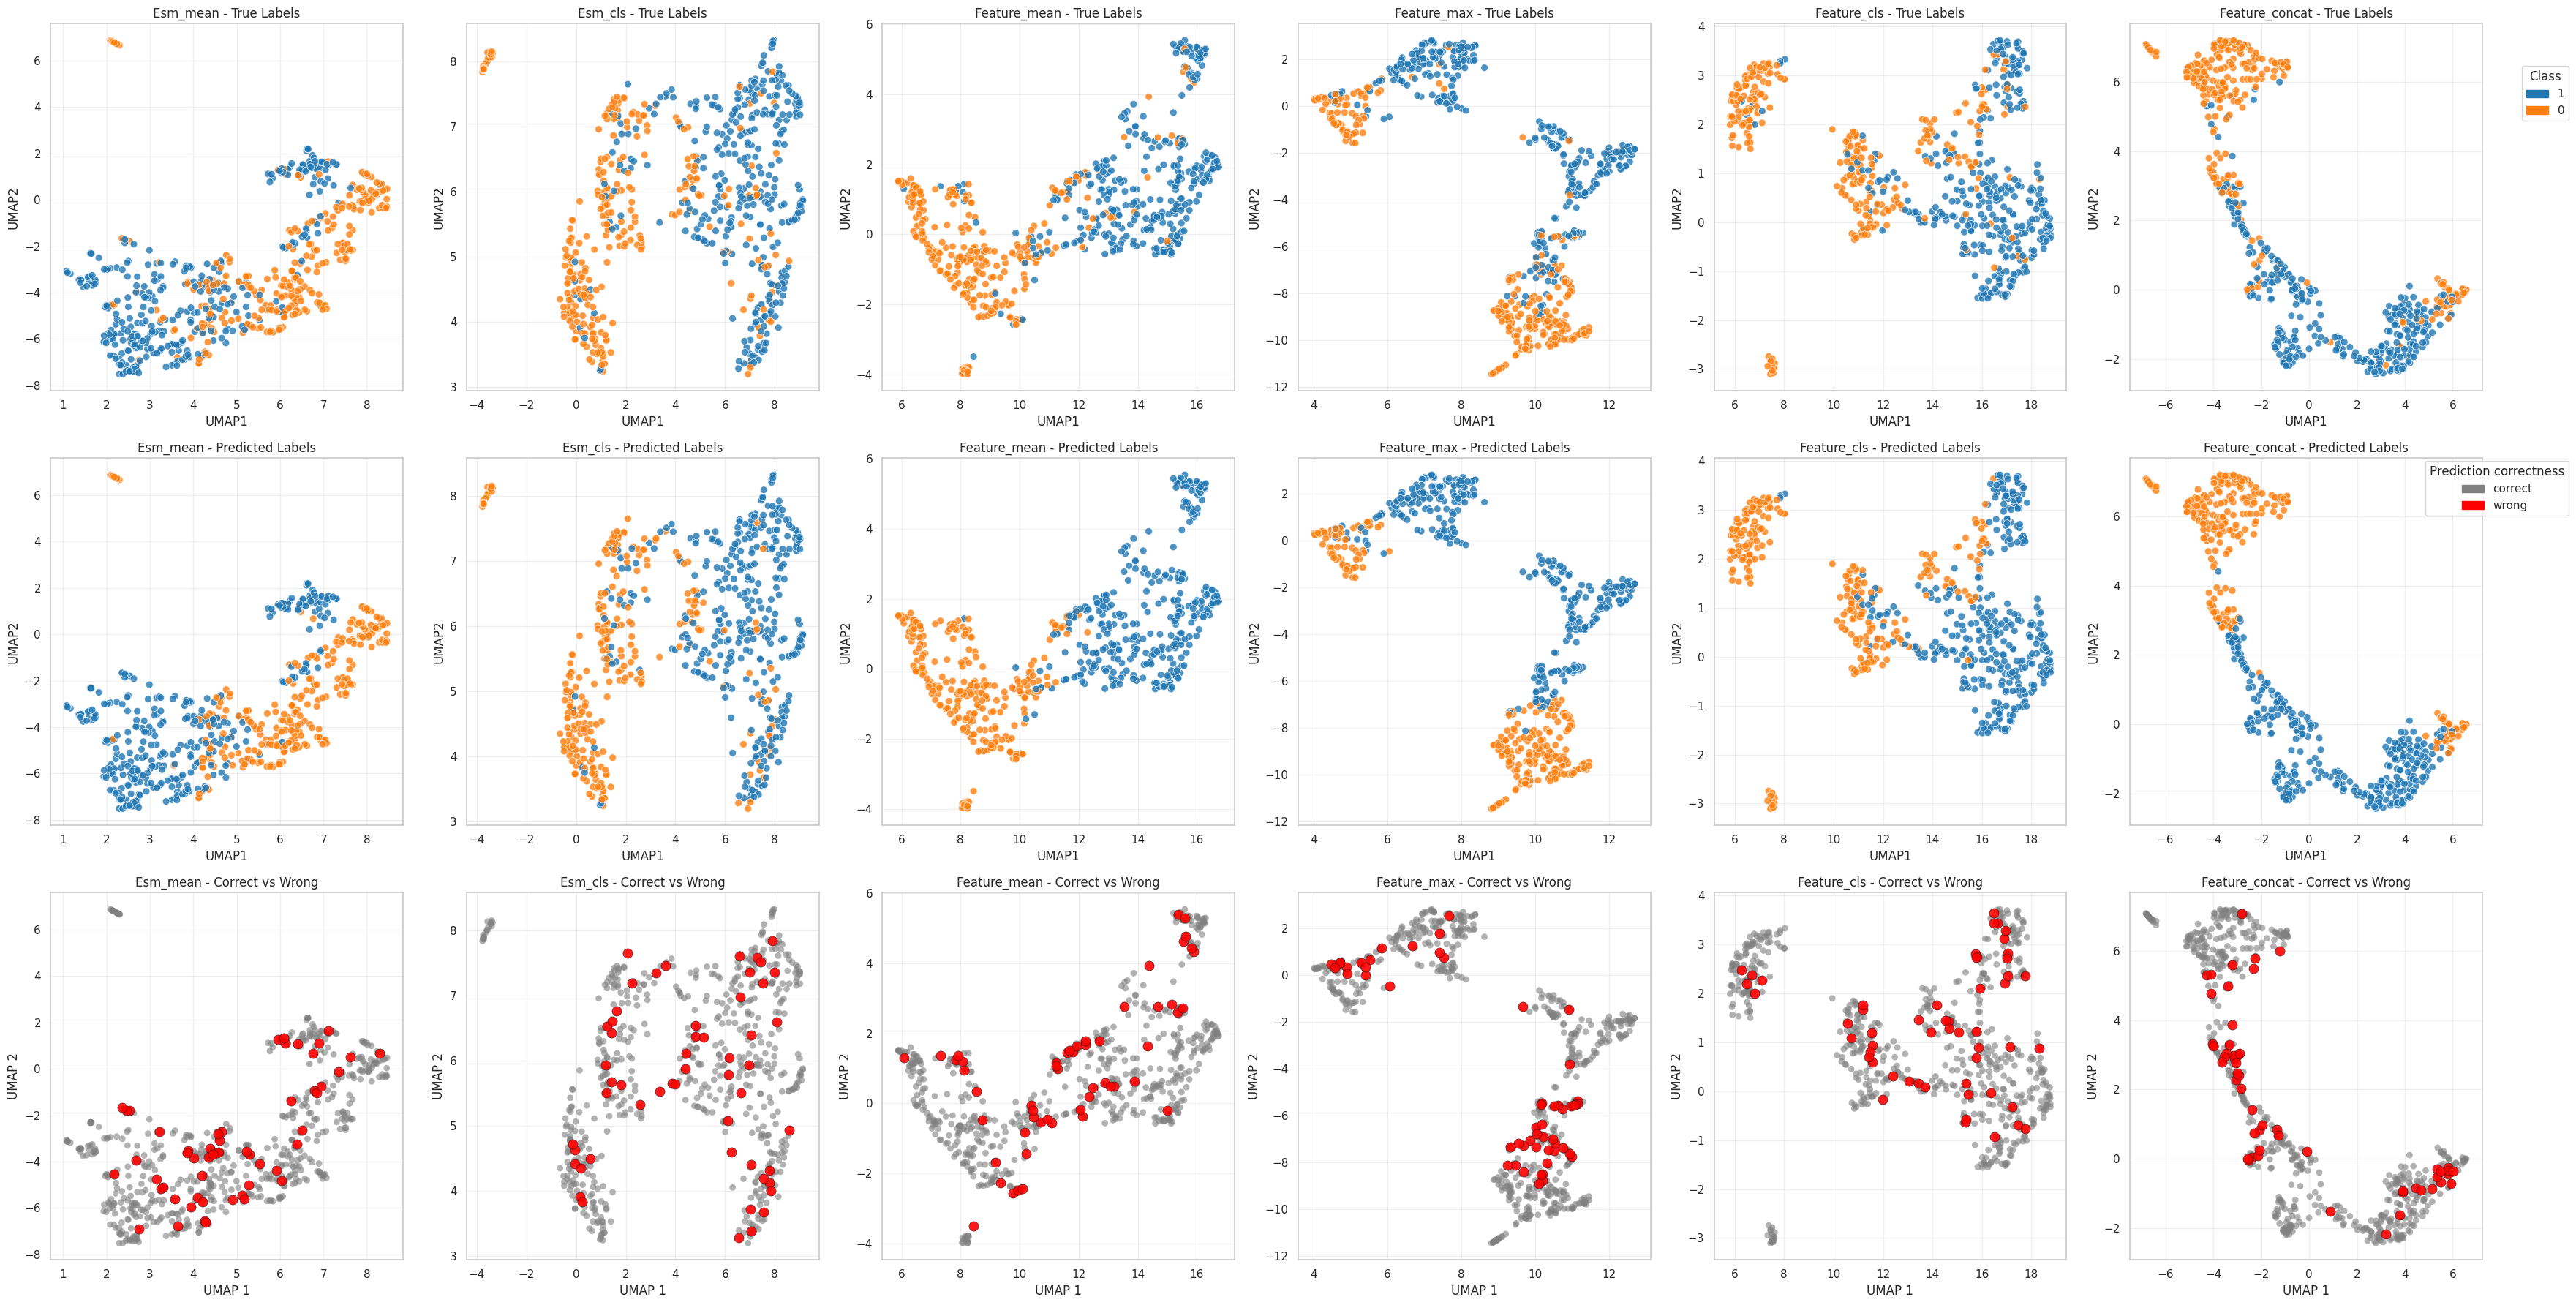

,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr
0,Q9UIQ6,-2.271002,5.797781,1,0,wrong
1,P01825,-1.055542,-2.014000,1,1,correct
2,P16298,-4.471114,6.395393,0,0,correct
3,P35443,-0.480855,0.040350,1,1,correct
4,P01876,-0.796580,-1.971419,1,1,correct
...,...,...,...,...,...,...
636,Q9BV23,-4.192116,3.801145,0,0,correct
637,P01178,2.735071,-2.381255,1,1,correct
638,Q14697,-1.982206,6.236601,0,0,correct
639,P01877,-0.833506,-2.006698,1,1,correct


In [12]:
DATALOADER = train_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

# Choose which embeddings you want to extract
which_embeddings = [
    "esm_mean",       # mean pooled ESM embeddings
    "esm_cls",        # CLS token embedding from ESM
    "feature_mean",   # mean pooled feature_fn embeddings
    "feature_max",    # max pooled feature_fn embeddings
    "feature_cls",    # CLS token from feature_fn
    "feature_concat"  # concatenated mean||max for classifier input
]

# Extract embeddings
train_embeddings, names, labels, predictions = mf.extract_embeddings(
    net=net,
    dl=train_dl,
    device=config["DEVICE"],
    which=which_embeddings,
    cls_index=0,      # index of CLS token in sequence
    return_numpy=True # set to False if you want torch tensors instead
)

# Example: check shapes
for key, emb in train_embeddings.items():
    print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

umap_tensors = mf.compute_umap_tensors(
    embeddings_dict=train_embeddings,
)

# Access UMAP DataFrame for feature_mean embeddings
df_feature_mean = umap_tensors['feature_mean']

#############################
###### PLOT
#############################

mf.plot_umap_embeddings(umap_tensors, names, labels, predictions, embedding_keys=which_embeddings)

esm_mean: (145, 320)
esm_cls: (145, 320)
feature_mean: (145, 320)
feature_max: (145, 320)
feature_cls: (145, 320)
feature_concat: (145, 640)
Computing UMAP for esm_mean with shape (145, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for esm_cls with shape (145, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_mean with shape (145, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_max with shape (145, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_cls with shape (145, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_concat with shape (145, 640)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


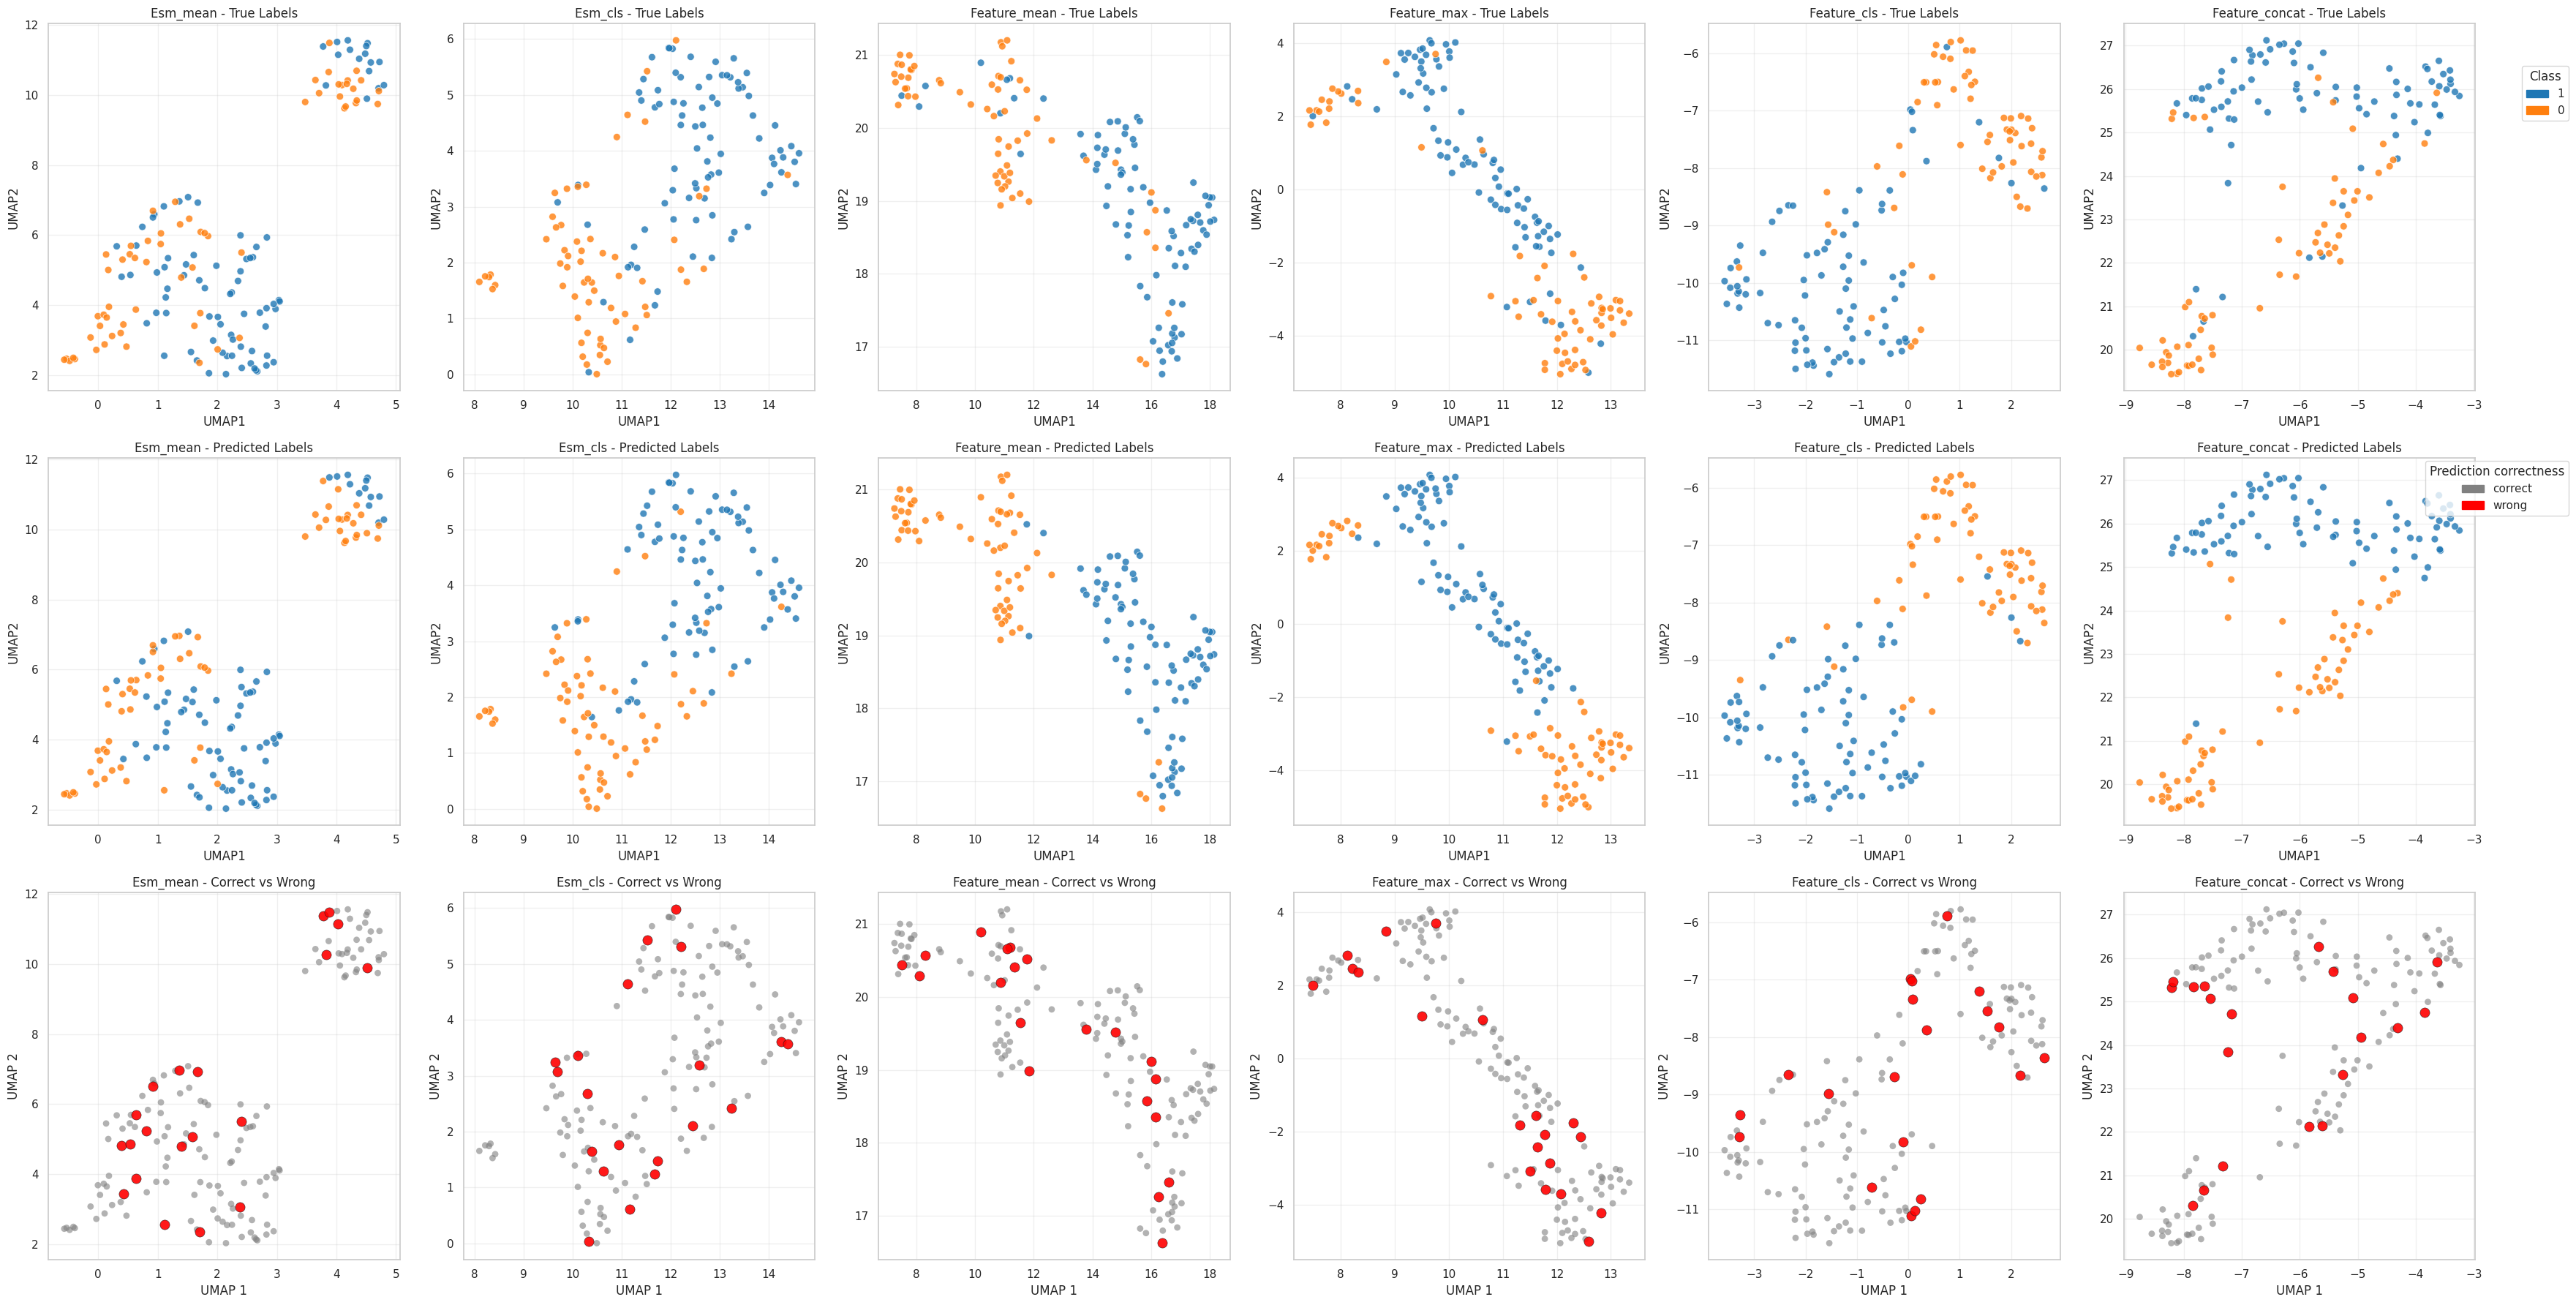

In [13]:
DATALOADER = test_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

# Choose which embeddings you want to extract
which_embeddings = [
    "esm_mean",       # mean pooled ESM embeddings
    "esm_cls",        # CLS token embedding from ESM
    "feature_mean",   # mean pooled feature_fn embeddings
    "feature_max",    # max pooled feature_fn embeddings
    "feature_cls",    # CLS token from feature_fn
    "feature_concat"  # concatenated mean||max for classifier input
]

# Extract embeddings
train_embeddings, names, labels, predictions = mf.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    which=which_embeddings,
    cls_index=0,      # index of CLS token in sequence
    return_numpy=True # set to False if you want torch tensors instead
)

# Example: check shapes
for key, emb in train_embeddings.items():
    print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

umap_tensors = mf.compute_umap_tensors(
    embeddings_dict=train_embeddings,
)

# Access UMAP DataFrame for feature_mean embeddings
df_feature_mean = umap_tensors['feature_mean']

#############################
###### PLOT
#############################

df = mf.plot_umap_embeddings(umap_tensors, names, labels, predictions, embedding_keys=which_embeddings)

In [ ]:
df

df[df['CorrectStr'] == 'wrong']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr
2,O94964,-5.264532,23.319353,1,0,wrong
5,P02786,-7.236736,23.835249,1,0,wrong
12,P14174,-4.316059,24.397644,1,0,wrong
13,P14735,-5.611644,22.146698,1,0,wrong
26,Q08345,-7.546025,25.066124,1,0,wrong
38,Q8TC92,-7.330908,21.216700,1,0,wrong
51,A6NMZ7,-7.182020,24.711058,1,0,wrong
56,O75354,-7.839465,20.316074,1,0,wrong
57,O75356,-7.658394,20.653833,1,0,wrong
78,P50607,-4.945840,24.180403,1,0,wrong


### A-scanning